In [29]:
import Global_Functions as gf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import time
timestr = time.strftime("%Y-%m-%d_%H-%M")

In [6]:
OPEN_FOLDER = '../Data/Preped_Data/'

In [7]:
image_path = "../Images/"
image_subfolder = image_path + "Endtime/"
image_folder = image_subfolder + timestr + "/"

gf.check_folder(image_path)
gf.check_folder(image_subfolder)
gf.check_folder(image_folder)

Folder already exists.
Creation of directory ../Images/Endtime/ successful.
Creation of directory ../Images/Endtime/2021-03-12_15-52/ successful.


In [8]:
ex_1 = gf.open_CSV_file('experiment_1_short.csv', OPEN_FOLDER)
ex_4 = gf.open_CSV_file('experiment_4_short.csv', OPEN_FOLDER)
ex_9 = gf.open_CSV_file('experiment_9_short.csv', OPEN_FOLDER)
ex_20 = gf.open_CSV_file('experiment_20_short.csv', OPEN_FOLDER)
ex_21 = gf.open_CSV_file('experiment_21_short.csv', OPEN_FOLDER)
ex_22 = gf.open_CSV_file('experiment_22_short.csv', OPEN_FOLDER)
ex_23 = gf.open_CSV_file('experiment_23_short.csv', OPEN_FOLDER)
ex_24 = gf.open_CSV_file('experiment_24_short.csv', OPEN_FOLDER)

In [61]:
def get_ends(col, delta = 50, epsilon = 0.01):
    end_splits = list()
    temp = []
    for x in range(delta, len(col)):
        part = col[x-delta:x]
        part_max = max(part)
        part_min = min(part)
        part_mean = np.mean(part)
        if part_max < (1+epsilon)*part_mean and part_min > (1-epsilon)*part_mean:
            temp.append(x)
    
    
    return end_splits

In [62]:
def get_splits(df):
    input_splits = [x for x in range(len(df)-1) if df.iloc[x]['input_voltage'] != df.iloc[x+1]['input_voltage']]
    end_splits = get_ends(df['el_power'])
    return input_splits, end_splits

In [63]:
get_splits(ex_1)

([2796, 5004, 7624],
 [422,
  423,
  424,
  425,
  426,
  427,
  428,
  429,
  430,
  431,
  432,
  433,
  434,
  435,
  436,
  437,
  438,
  439,
  440,
  441,
  487,
  488,
  489,
  490,
  491,
  492,
  493,
  494,
  495,
  496,
  497,
  498,
  499,
  500,
  501,
  502,
  503,
  504,
  505,
  506,
  507,
  508,
  509,
  510,
  511,
  512,
  513,
  514,
  515,
  516,
  517,
  518,
  519,
  520,
  521,
  522,
  523,
  524,
  525,
  526,
  527,
  528,
  529,
  530,
  531,
  532,
  533,
  534,
  535,
  536,
  537,
  538,
  539,
  540,
  541,
  542,
  543,
  544,
  545,
  546,
  547,
  548,
  549,
  550,
  551,
  552,
  553,
  554,
  575,
  594,
  595,
  596,
  597,
  598,
  599,
  600,
  601,
  602,
  603,
  604,
  605,
  606,
  607,
  608,
  609,
  610,
  611,
  612,
  613,
  614,
  615,
  616,
  617,
  618,
  619,
  620,
  621,
  622,
  623,
  624,
  625,
  626,
  627,
  628,
  629,
  630,
  631,
  632,
  633,
  634,
  635,
  636,
  637,
  638,
  639,
  640,
  641,
  642,
  643,
  644,

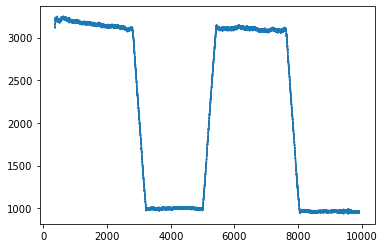

In [39]:
plt.plot(ex_1['el_power'][360:])